# Cryptocurrency Analysis & Predictions
The current challenge was set my Imperial College London

Link to their repo: https://github.com/Imperial-College-Data-Science-Society/Challenges/tree/master/cryptocurrency-trading

I'll explain my current thought processes and continue to delve into the data

# Import packages

In [1]:
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [13]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import json
from keras import losses 
from keras import optimizers 
from keras import metrics
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
color = sns.color_palette()


%matplotlib inline

# Import Data

In [3]:
raw_data = pd.read_csv("../Data/dataset.csv", encoding="utf_8")

# Explore Data

Current thoughts:
- Try understand the data
    - Which are the most important columns?
    - Which columns can I ignore?

In [4]:
raw_data.head(3)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,28/04/2013,1,135.30,135.98,132.10,134.21,0.0,1.500520e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,29/04/2013,1,134.44,147.49,134.00,144.54,0.0,1.491160e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,30/04/2013,1,144.00,146.93,134.05,139.00,0.0,1.597780e+09,0.3843,12.88


In [5]:
explore = raw_data.copy()
explore['date'] = pd.to_datetime(explore['date'])

In [7]:
new_explore = explore.set_index("date")
new_explore.index = pd.to_datetime(new_explore.index, unit='s')
target_col = 'close'

In [8]:
new_explore["close"] = new_explore["close"].astype(int)

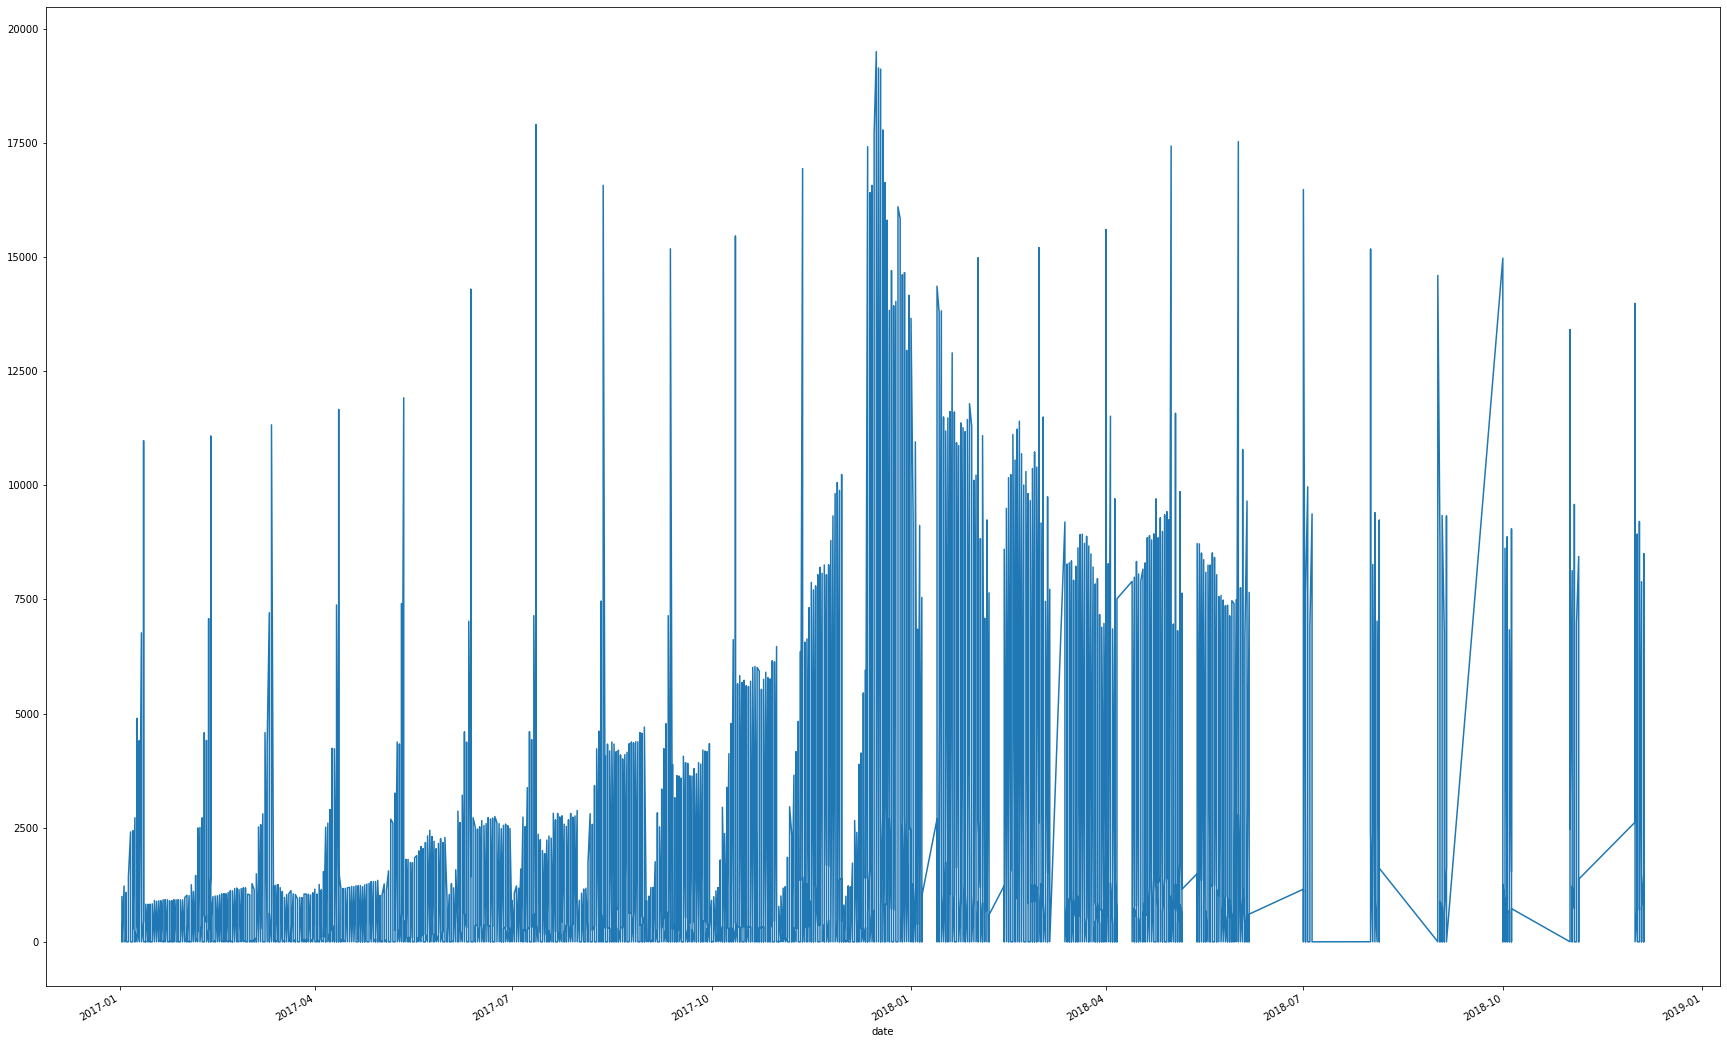

In [9]:
new_explore.loc[new_explore.index > pd.to_datetime('01-01-2017')]['close'].plot(figsize=(30,20))

# Prediction

Link: https://github.com/abhinavsagar/cryptocurrency-price-prediction/blob/master/price_prediction.ipynb

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(new_explore, test_size=0.25)

In [11]:
train["close"]=pd.to_numeric(train.close,errors='coerce') #turning the Close column to numeric
train = train.dropna() #romeving the NA values
trainData = train.iloc[:,7:8].values #selecting only the closing prices for training

<ipython-input-11-9acdf0fc953d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(3741, 1)

In [15]:
X_train = []
y_train = []

for i in range (60,len(train)): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [16]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(3681, 60, 1)

In [17]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [18]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
116/116 - 28s - loss: 0.0137
Epoch 2/20
116/116 - 22s - loss: 0.0135
Epoch 3/20
116/116 - 23s - loss: 0.0136
Epoch 4/20
116/116 - 18s - loss: 0.0136
Epoch 5/20
116/116 - 20s - loss: 0.0135
Epoch 6/20
116/116 - 24s - loss: 0.0135
Epoch 7/20
116/116 - 22s - loss: 0.0135
Epoch 8/20
116/116 - 26s - loss: 0.0135
Epoch 9/20
116/116 - 26s - loss: 0.0134
Epoch 10/20
116/116 - 26s - loss: 0.0135
Epoch 11/20
116/116 - 21s - loss: 0.0135
Epoch 12/20
116/116 - 26s - loss: 0.0135
Epoch 13/20
116/116 - 22s - loss: 0.0135
Epoch 14/20
116/116 - 25s - loss: 0.0135
Epoch 15/20
116/116 - 27s - loss: 0.0135
Epoch 16/20
116/116 - 26s - loss: 0.0135
Epoch 17/20
116/116 - 27s - loss: 0.0135
Epoch 18/20
116/116 - 27s - loss: 0.0135
Epoch 19/20
116/116 - 26s - loss: 0.0135
Epoch 20/20
116/116 - 23s - loss: 0.0135


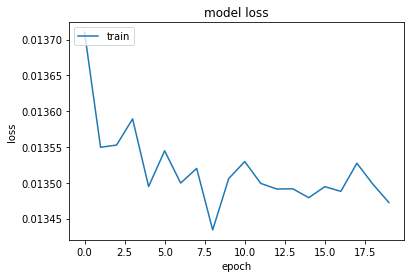

In [19]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [20]:
test["close"]=pd.to_numeric(test.close,errors='coerce') #turning the close column to numerical type
test = test.dropna() #droping the NA values
test = test.iloc[:,7:8] #selecting the closing prices for testing
y_test = test.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = test.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(test)
timestep = 60
for i in range(timestep,length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

<ipython-input-20-0203217fdf6f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1187, 60, 1)

In [21]:
y_pred = model.predict(X_test) #predicting the new values

In [22]:
predicted_price = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting

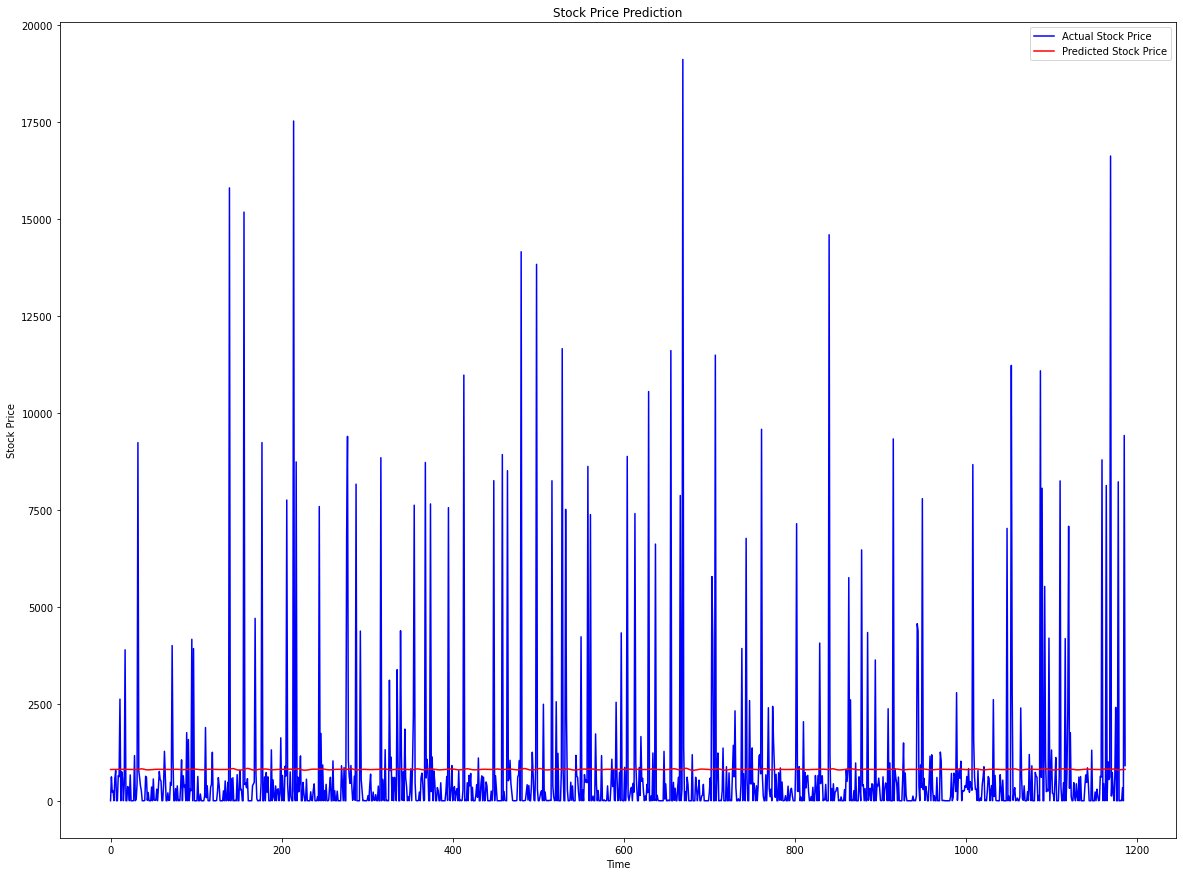

In [23]:
plt.figure(figsize=(20, 15))
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Test 2

In [60]:
explore = raw_data.copy()
explore['date'] = pd.to_datetime(explore['date'])

In [70]:
explore = explore[explore["slug"]== "bitcoin"]
explore = explore[explore["date"] >= 2017]

TypeError: Invalid comparison between dtype=datetime64[ns] and int

In [62]:
explore["PV"]=((explore["high"] + explore["low"] + explore["close"])/3)*explore["volume"]
explore["WVAP"] = explore["PV"]/explore["volume"]
explore = explore.fillna(0)

In [63]:
group = explore.groupby('date')
Real_Price = group['WVAP'].mean()

In [64]:
prediction_days = 30
df_train= Real_Price[len(Real_Price)-prediction_days:]
df_test= Real_Price[:len(Real_Price)-prediction_days]

In [65]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [66]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [67]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.0645
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0637
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0626
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0625
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0619
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0615
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0611
Epoch 11/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0610
Epoch 12/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0609
Epoch 13/100
6/6 [==============================] - 0s 4ms/st

In [68]:
test_set = df_test.values[1:]
sc = MinMaxScaler(feature_range=(0,1))
inputs = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
inputs = sc.fit_transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

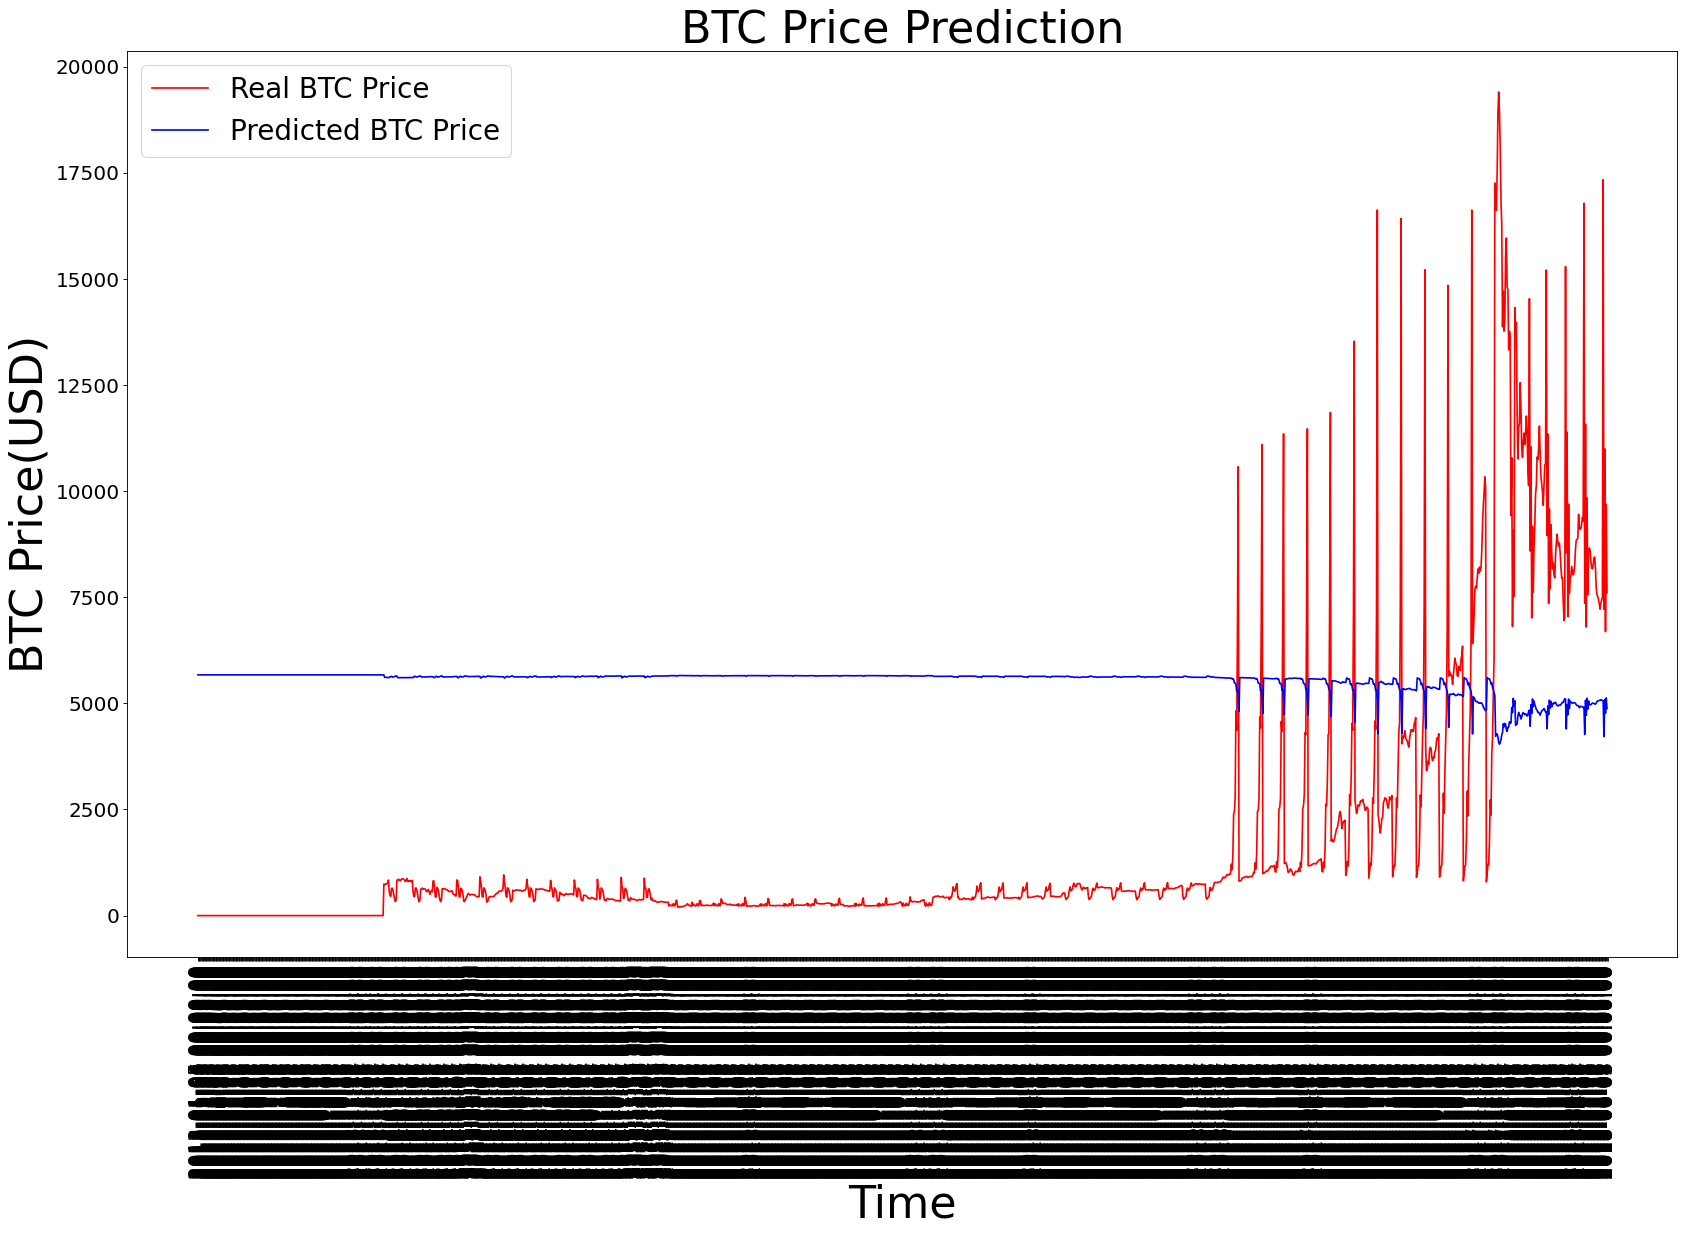

In [69]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

The current Model isn't as effective as I would've hoped. I'll spend time further revising this project...